In [ ]:
#!unzip /content/Train.zip

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform

In [ ]:
data = ImageFolder('/content/Train/',transform=transform.ToTensor())

In [ ]:
data

Dataset ImageFolder
    Number of datapoints: 56
    Root location: /content/Train/
    StandardTransform
Transform: ToTensor()

In [ ]:
data[0][0].shape

torch.Size([3, 217, 181])

In [ ]:
from torch.utils.data import Subset

In [ ]:
t1_train = Subset(data,list(range(0,28)))

In [ ]:
t2_train = Subset(data,list(range(28,56)))

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
t1_train_dl = DataLoader(t1_train,1)
t2_train_dl = DataLoader(t2_train,1)

In [ ]:
img = t1_train_dl

In [ ]:
for im,l in t1_train_dl:
  print(im,l)
  break

tensor([[[[0.0118, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0157, 0.0157,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0078, 0.0078],
          ...,
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0118, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0157, 0.0157,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0078, 0.0078],
          ...,
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0118, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0157, 0.0157,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0

In [ ]:
len(t1_train_dl)

28

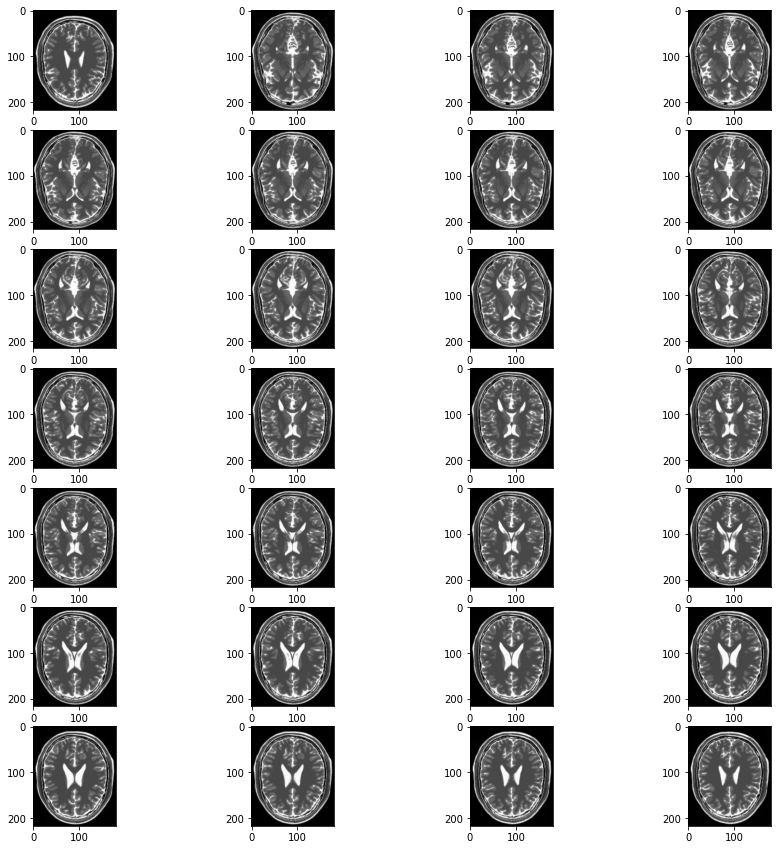

In [ ]:
ax,fig = plt.subplots(7,4,figsize=(15,15))
r=c=1
for img,lab in t1_train_dl:
  fig[r-1][c-1].imshow(img[0].permute(1,2,0),cmap='gray')
  #plt.show()
  if c%4==0:
    r = r+1
  c = (c+1)%4

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [ ]:
class BaseClass(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def traning_step(self,batch):
    img, labl = batch
    pred = self(img)
    loss = F.cross_entropy(pred,labl)
    return loss

  def accuracy(self,pred,target):
    _,pred = th.max(pred,dim=1)
    return th.tensor(th.sum(pred==target).item()/len(target))
  
  def validation_step(self,batch):
    img,labl = batch
    pred = self(img)
    loss = F.cross_entropy(pred,labl)
    acc = self.accuracy(pred,labl)
    return [loss.detach(),acc]
  
  def epoch_end(self,epoch,result):
    print('Epoch[{}], traning_loss: {:,4f}, val_loss: {:,4f}, val_acc: {:,4f}, val_acc: {:,4f} '.format(epoch,result['loss'],result['val_loss'],result['val_acc']))



  

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Mod2(nn.Module):
  def __init__(self):
    super(Mod2,self).__init__()
    self.lay1 = nn.Conv2d(3,32,3,2,1)
    self.lay2 = nn.Conv2d(32,64,3,2,1)
    self.lay3 = nn.Conv2d(64,128,3,1,0)#53.0 44.0

    self.mean = nn.Linear(128*53*44,128)
    self.log_var = nn.Linear(128*53*44,128)
    
    self.decFCL = nn.Linear(128,128*53*44)
    self.declay2 = nn.ConvTranspose2d(128,64,3,1,0)
    self.declay1 = nn.ConvTranspose2d(64,32,3,2,1)
    self.declay0 = nn.ConvTranspose2d(32,3,3,2,1)


  def encoder(self,x):
    #print('enlay1')
    x = F.leaky_relu(self.lay1(x))
    #print('enlay2')
    x = F.leaky_relu(self.lay2(x))
    #print('enlay3')
    x = F.leaky_relu(self.lay3(x))
    #print('enlay4')
    x = x.view(-1,128*53*44)
    mu = self.mean(x)
    logvar = self.log_var(x)
    #print('outenco')
    return mu,logvar

  def reparameterize(self, mu, logVar):
    #print('repstp1')
    std = th.exp(logVar/2)
    #print('repstp2')
    eps = th.randn_like(std)
    #print('repOut')
    return mu + std * eps


  def decoder(self,x):
    #print('declay1')
    x = F.leaky_relu(self.decFCL(x))
    #print('declay2')
    x = x.view(-1,128,53,44)
    #print('declay3')
    x = F.leaky_relu(self.declay2(x))
    #print('declay4')
    x = F.leaky_relu(self.declay1(x))
    #print('declay5')
    #x = F.pad(x,(0,0,2,0))
    x = F.leaky_relu(self.declay0(x))
    #print('declay6')
    x = F.sigmoid(x)
    #print('decOut')
    return x



  def forward(self,x):
    #print('Encoder..')
    mu,logvar = self.encoder(x)
    #print('Rep')
    z = self.reparameterize(mu,logvar)
    #print('Decoy')
    out = self.decoder(z)
    return out,mu,logvar



In [ ]:
from torchvision import datasets
import torchvision.transforms as transform

In [ ]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 0.0004
num_epochs = 20




In [ ]:
from tqdm import tqdm

In [ ]:

"""
Initialize the network and the Adam optimizer
"""
device='cuda'
net = Mod2().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in tqdm(range(num_epochs)):
    ii = 0
    for idx, data in enumerate(t1_train_dl, 0):
        tar = t2_train[ii][0].to(device)
        imgs, _ = data
        #print(imgs.shape)
        #imgs = imgs[0]
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out, tar) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('l> : ',float(loss))
        ii = ii + 1

    print('Epoch {}: Loss {}'.format(epoch, loss))

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Using a target size (torch.Size([3, 217, 181])) that is different to the input size (torch.Size([1, 3, 217, 181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  5%|▌         | 1/20 [00:02<00:46,  2.46s/it]

Epoch 0: Loss 0.17060089111328125


 10%|█         | 2/20 [00:04<00:43,  2.43s/it]

Epoch 1: Loss 0.13536617159843445


 15%|█▌        | 3/20 [00:07<00:41,  2.42s/it]

Epoch 2: Loss 0.11350984871387482


 20%|██        | 4/20 [00:09<00:38,  2.42s/it]

Epoch 3: Loss 0.110392726957798


 25%|██▌       | 5/20 [00:12<00:36,  2.42s/it]

Epoch 4: Loss 0.09487730264663696


 30%|███       | 6/20 [00:14<00:33,  2.41s/it]

Epoch 5: Loss 0.061269305646419525


 35%|███▌      | 7/20 [00:16<00:31,  2.41s/it]

Epoch 6: Loss 0.06481404602527618


 40%|████      | 8/20 [00:19<00:28,  2.41s/it]

Epoch 7: Loss 0.05201368406414986


 45%|████▌     | 9/20 [00:21<00:26,  2.41s/it]

Epoch 8: Loss 0.07208327203989029


 50%|█████     | 10/20 [00:24<00:24,  2.41s/it]

Epoch 9: Loss 0.08725720643997192


 55%|█████▌    | 11/20 [00:26<00:21,  2.41s/it]

Epoch 10: Loss 0.051479555666446686


 60%|██████    | 12/20 [00:28<00:19,  2.41s/it]

Epoch 11: Loss 0.0490497462451458


 65%|██████▌   | 13/20 [00:31<00:16,  2.41s/it]

Epoch 12: Loss 0.05664994940161705


 70%|███████   | 14/20 [00:33<00:14,  2.41s/it]

Epoch 13: Loss 0.06534891575574875


 75%|███████▌  | 15/20 [00:36<00:12,  2.41s/it]

Epoch 14: Loss 0.04449164494872093


 80%|████████  | 16/20 [00:38<00:09,  2.41s/it]

Epoch 15: Loss 0.03945045545697212


 85%|████████▌ | 17/20 [00:41<00:07,  2.41s/it]

Epoch 16: Loss 0.0503738671541214


 90%|█████████ | 18/20 [00:43<00:04,  2.41s/it]

Epoch 17: Loss 0.03901528939604759


 95%|█████████▌| 19/20 [00:45<00:02,  2.41s/it]

Epoch 18: Loss 0.05036496743559837


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]

Epoch 19: Loss 0.05089651793241501


In [ ]:
for img,lab in t1_train_dl:
  #print('Real\n',img)
  #plt.imshow(img[0].permute(1,2,0))
  img2 = img.to(device)
  im = net.forward(img2)
  im = im[0][0].permute(1,2,0)
  im = im.cpu().detach().numpy()
  #print(im)
  plt.imshow(im)
  plt.show()
  #break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


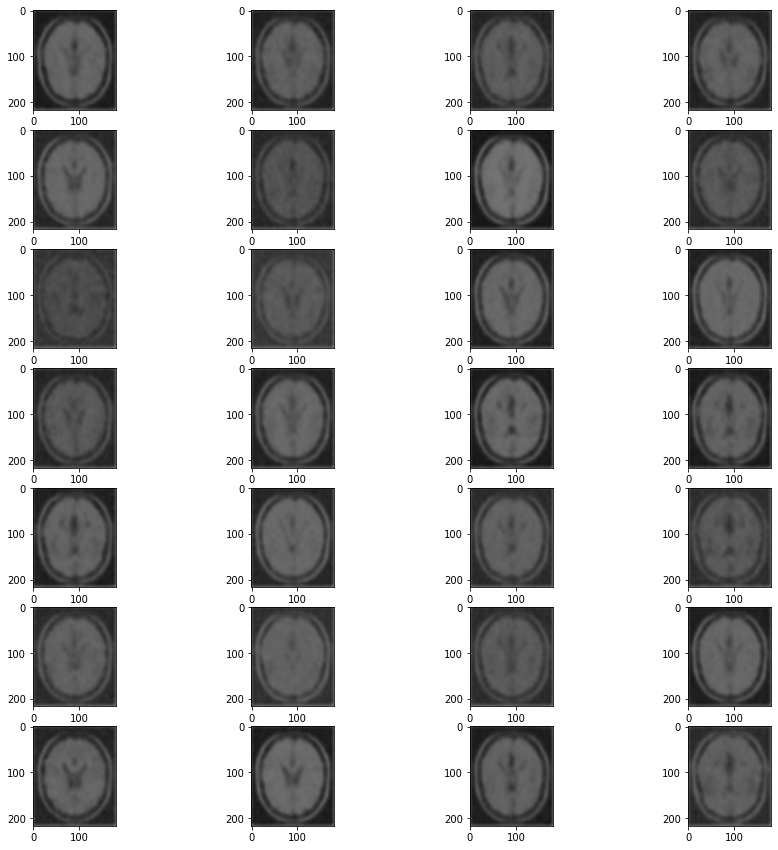

In [ ]:
ax,fig = plt.subplots(7,4,figsize=(15,15))
r=c=1
for img,lab in t1_train_dl:
  img2 = img.to(device)
  im = net.forward(img2)
  im = im[0][0].permute(1,2,0)
  im = im.cpu().detach().numpy()
  fig[r-1][c-1].imshow(im,cmap='gray')
  #plt.show()
  if c%4==0:
    r = r+1
  c = (c+1)%4

In [ ]:
th.save(net,'Model1')